In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Augmentation을 적용한 데이터셋 만들기
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?


예시답안
CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

In [3]:
batch_size = 16

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [4]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [5]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [6]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [7]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label



In [9]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def apply_normalize_on_dataset2(ds, is_test=False, batch_size=16, with_aug=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [24]:
ds_train_no_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size
)

In [13]:
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True
)

In [31]:
ds_train_aug_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=True
)

In [35]:
ds_train_aug_mixup = apply_normalize_on_dataset2(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_mixup=True
)

In [16]:
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# 2. 모델 만들기
앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [17]:
num_classes = ds_info.features["label"].num_classes

In [18]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [19]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [20]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])                                               

In [21]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# 3. 모델 훈련하기
모델을 훈련시켜 주세요.

힌트: 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해주세요!

Q3. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?

0
예시답안
우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

# 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

In [22]:
tf.random.set_seed(2020)

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [25]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 119s 159ms/step - loss: 2.2038 - accuracy: 0.4418 - val_loss: 3.2791 - val_accuracy: 0.2246
Epoch 2/20
750/750 [==============================] - 120s 160ms/step - loss: 0.7570 - accuracy: 0.7918 - val_loss: 1.1065 - val_accuracy: 0.6791
Epoch 3/20
750/750 [==============================] - 123s 164ms/step - loss: 0.2925 - accuracy: 0.9312 - val_loss: 0.9822 - val_accuracy: 0.7097
Epoch 4/20
750/750 [==============================] - 123s 164ms/step - loss: 0.1154 - accuracy: 0.9829 - val_loss: 1.0126 - val_accuracy: 0.7092
Epoch 5/20
750/750 [==============================] - 123s 165ms/step - loss: 0.0515 - accuracy: 0.9957 - val_loss: 0.9274 - val_accuracy: 0.7386
Epoch 6/20
750/750 [==============================] - 124s 165ms/step - loss: 0.0337 - accuracy: 0.9965 - val_loss: 0.9143 - val_accuracy: 0.7459
Epoch 7/20
750/750 [==============================] - 122s 163ms/step - loss: 0.0163 - accuracy: 0.9987 - val_loss: 0.9176 -

In [26]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 118s 157ms/step - loss: 2.2510 - accuracy: 0.4372 - val_loss: 2.9458 - val_accuracy: 0.2787
Epoch 2/20
750/750 [==============================] - 122s 162ms/step - loss: 0.9283 - accuracy: 0.7293 - val_loss: 1.2717 - val_accuracy: 0.6299
Epoch 3/20
750/750 [==============================] - 122s 163ms/step - loss: 0.5295 - accuracy: 0.8503 - val_loss: 1.1450 - val_accuracy: 0.6667
Epoch 4/20
750/750 [==============================] - 117s 156ms/step - loss: 0.3044 - accuracy: 0.9233 - val_loss: 1.0132 - val_accuracy: 0.7107
Epoch 5/20
750/750 [==============================] - 115s 153ms/step - loss: 0.1542 - accuracy: 0.9673 - val_loss: 0.9578 - val_accuracy: 0.7222
Epoch 6/20
750/750 [==============================] - 119s 159ms/step - loss: 0.1045 - accuracy: 0.9821 - val_loss: 0.9693 - val_accuracy: 0.7254
Epoch 7/20
750/750 [==============================] - 122s 163ms/step - loss: 0.0835 - accuracy: 0.9854 - val_loss: 1.0329 -

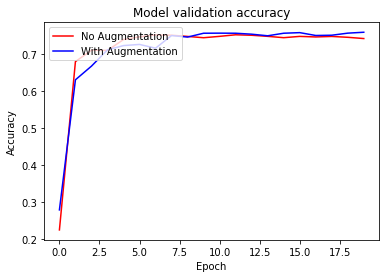

In [27]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

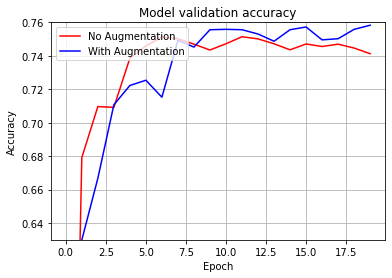

In [36]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.63, 0.76)
plt.show()

In [32]:
history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 130s 174ms/step - loss: 3.8676 - accuracy: 0.1963 - val_loss: 3.1439 - val_accuracy: 0.2508
Epoch 2/20
750/750 [==============================] - 128s 171ms/step - loss: 2.9941 - accuracy: 0.4077 - val_loss: 1.5598 - val_accuracy: 0.5665
Epoch 3/20
750/750 [==============================] - 128s 171ms/step - loss: 2.7086 - accuracy: 0.5012 - val_loss: 1.6114 - val_accuracy: 0.5663
Epoch 4/20
750/750 [==============================] - 128s 171ms/step - loss: 2.5382 - accuracy: 0.5505 - val_loss: 1.2434 - val_accuracy: 0.6515
Epoch 5/20
750/750 [==============================] - 124s 165ms/step - loss: 2.4329 - accuracy: 0.5838 - val_loss: 1.4059 - val_accuracy: 0.6163
Epoch 6/20
750/750 [==============================] - 120s 160ms/step - loss: 2.3063 - accuracy: 0.6185 - val_loss: 1.2797 - val_accuracy: 0.6494
Epoch 7/20
750/750 [==============================] - 129s 172ms/step - loss: 2.2191 - accuracy: 0.6485 - val_loss: 1.2586 -

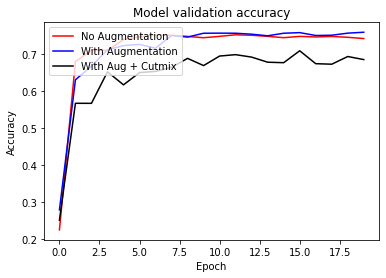

In [33]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix'], loc='upper left')
plt.show()

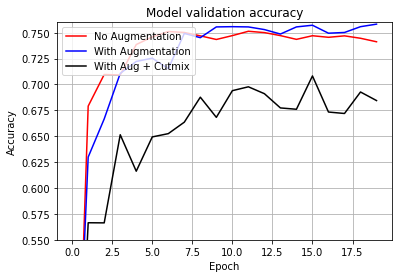

In [41]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 0.76)
plt.show()

In [37]:
history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 129s 172ms/step - loss: 3.7380 - accuracy: 0.2341 - val_loss: 3.5030 - val_accuracy: 0.1791
Epoch 2/20
750/750 [==============================] - 127s 170ms/step - loss: 2.9027 - accuracy: 0.4604 - val_loss: 1.4730 - val_accuracy: 0.5935
Epoch 3/20
750/750 [==============================] - 129s 172ms/step - loss: 2.6745 - accuracy: 0.5455 - val_loss: 1.2270 - val_accuracy: 0.6538
Epoch 4/20
750/750 [==============================] - 127s 170ms/step - loss: 2.5021 - accuracy: 0.6043 - val_loss: 1.2856 - val_accuracy: 0.6346
Epoch 5/20
750/750 [==============================] - 128s 170ms/step - loss: 2.3784 - accuracy: 0.6543 - val_loss: 2.2980 - val_accuracy: 0.4473
Epoch 6/20
750/750 [==============================] - 128s 170ms/step - loss: 2.3075 - accuracy: 0.6748 - val_loss: 1.3992 - val_accuracy: 0.6249
Epoch 7/20
750/750 [==============================] - 134s 179ms/step - loss: 2.2254 - accuracy: 0.7089 - val_loss: 1.1867 -

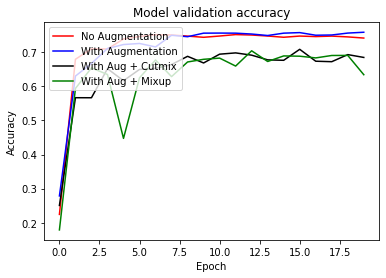

In [38]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix', 'With Aug + Mixup'], loc='upper left')
plt.show()

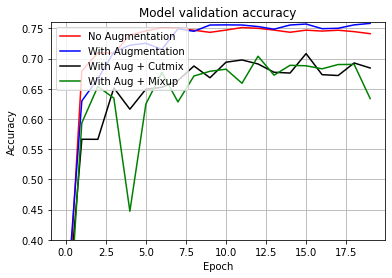

In [39]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix', 'With Aug + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.4, 0.76)
plt.show()

# 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

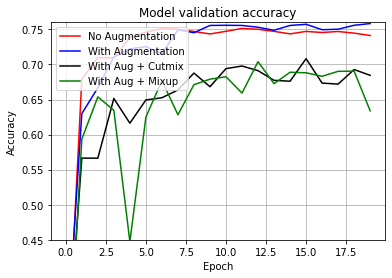

In [43]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug + Cutmix', 'With Aug + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.45, 0.76)
plt.show()

유감(?) 스럽게도 augmentaion으로만 돌린게 accuracy가 잘나왔다. 